In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


# Loading and Preprocessing Data

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [4]:
X_train = train.iloc[:,1:]
Y_train = train.iloc[:,:1]
X_train.shape
Y_train.shape

(42000, 1)

In [5]:
X_test = test

In [6]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [7]:
X_test = np.asarray(X_test)

In [8]:
import sklearn.model_selection as skm

In [9]:
X_train, X_val, Y_train, Y_val = skm.train_test_split(X_train, Y_train, stratify = Y_train, shuffle= True, random_state=0)

In [10]:
X_train = np.reshape(X_train,(31500, 1, 28,28))
X_val = np.reshape(X_val,(10500, 1, 28, 28))
X_test = np.reshape(X_test,(28000,1, 28,28))

In [11]:
X_train.shape

(31500, 1, 28, 28)

In [12]:
Y_train = Y_train.reshape([31500,])
Y_val = Y_val.reshape([10500,])

# CNN

In [13]:
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [14]:
X_train, X_val, Y_train, Y_val, X_test = map(torch.tensor, (X_train, X_val, Y_train, Y_val, X_test))

In [15]:
X_train.shape

torch.Size([31500, 1, 28, 28])

In [16]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  print(pred)
  print(y)
  return (pred == y).float().mean()

In [17]:
X_train[0].shape

torch.Size([1, 28, 28])

In [18]:
torch.manual_seed(0)

In [19]:
class modelv2(nn.Module):
    def __init__(self):
        
        super(modelv2, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 5), # (N, 1, 28, 28) -> (N, 6, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=(2,2)), # (N, 6, 24, 24) -> (N, 6, 12, 12)
            nn.Conv2d(6, 16, 5), # (N, 6, 12, 12) -> (N, 16, 8, 8) 
            nn.ReLU(),
            nn.AvgPool2d(2, stride=(2,2)) # (N, 16, 8, 8) -> (N, 16, 4, 4)
        )
        self.fcn = nn.Sequential(
            nn.Linear(256, 100), #(N, 256) -> (N, 100)
            nn.ReLU(),
            nn.Linear(100, 10) #(N, 100) -> (N, 10)
        )
        def init_weights(m):
            if type(m) == nn.Linear:
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity = 'relu')
                m.bias.data.fill_(0.01)
            
        self.fcn.apply(init_weights)
        self.cnn.apply(init_weights)
    
    def forward(self, X):
        y = self.cnn(X)
        y = y.view(y.size(0), -1)
        return self.fcn(y)

In [20]:
def fitv1(X, Y,model, lossfn,opt , epochs = 1):
    loss_per_epoch = []
    for i in range(epochs):
        opt.zero_grad()
        output = model(X)
    
        loss = lossfn(output, Y)
        loss_per_epoch.append(loss)
        loss.backward()
        #print("Epoch", i)
    
        opt.step()
    
    plt.plot(loss_per_epoch)
    plt.xlabel('Epochs')
    plt.ylabel('CE Loss')
    plt.show()

In [21]:
model = modelv2()

In [22]:
lossfn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.0095, weight_decay=0.00001)

In [23]:
X_train.shape

torch.Size([31500, 1, 28, 28])

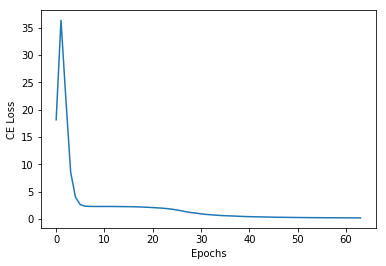

In [24]:
fitv1(X_train.float(), Y_train.long(),model, lossfn, opt, epochs=64)

In [25]:
print(accuracy(model(X_train.float()), Y_train.long()))

tensor([1, 3, 9,  ..., 9, 9, 9])
tensor([1, 3, 9,  ..., 4, 8, 9])
tensor(0.9459)


In [26]:
print(model(X_train.float()))

tensor([[-1.4787, 13.4028,  1.6895,  ...,  2.6662,  5.2251, -4.0621],
        [ 0.1370, -7.3840,  0.0936,  ..., -1.5255, -0.6724,  3.8287],
        [ 1.5173, -5.2832,  4.0366,  ...,  6.9316,  2.4558, 14.7792],
        ...,
        [-2.1089,  6.2344,  2.6118,  ...,  6.9491,  0.2888,  7.1638],
        [-1.7169, -3.3061, -0.3276,  ...,  4.0416,  2.1757,  8.2519],
        [-0.4478, -7.7638, -0.2301,  ...,  5.3206,  5.8786, 10.9297]],
       grad_fn=<AddmmBackward>)


In [27]:
print(accuracy(model(X_val.float()), Y_val.long()))

tensor([1, 1, 5,  ..., 5, 8, 7])
tensor([1, 1, 5,  ..., 5, 8, 7])
tensor(0.9436)


In [28]:
Y_test = model(X_test.float())

In [29]:
print(Y_test.shape)

torch.Size([28000, 10])


In [30]:
Y_test = torch.argmax(Y_test, dim=1)

In [31]:
Y_test

tensor([2, 0, 9,  ..., 3, 9, 2])

In [32]:
X = [i for i in range(1, 28001)]

In [33]:
submission = pd.DataFrame({'ImageId':X, 'Label':Y_test})
submission = submission[['ImageId', 'Label']]
submission['Label'].value_counts()

1    3247
7    2897
9    2821
2    2793
0    2780
6    2754
4    2740
3    2722
8    2721
5    2525
Name: Label, dtype: int64

In [34]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3


In [35]:
submission.to_csv("submission.csv", index=False)